In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akaiinu/crema-d")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/crema-d


In [3]:
%pip install librosa torchinfo

Note: you may need to restart the kernel to use updated packages.


In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import glob
import os
import random
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.model_selection import train_test_split
from typing import List

In [5]:
SAMPLE_RATE = 22050
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 1024
MAX_AUDIO_LENGTH = 4

In [6]:
import torch
import librosa
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2FeatureExtractor
from sklearn.preprocessing import LabelEncoder

class WavLMDataset(Dataset):
    def __init__(self, dataframe, audio_dir, processor_name="microsoft/wavlm-base-plus", transform=False, max_duration=3.0):
        """
        Args:
            dataframe: DataFrame chứa cột 'filepath' và 'emotion'
            audio_dir: Đường dẫn gốc tới thư mục audio (nếu filepath chưa full)
            processor_name: Tên model WavLM trên HuggingFace
            transform: True để bật data augmentation (trên raw waveform)
            max_duration: Độ dài tối đa của file audio (tính bằng giây) để cắt/pad
        """
        self.dataframe = dataframe
        self.audio_dir = audio_dir
        self.transform = transform
        self.max_duration = max_duration
        self.target_sr = 16000 

        self.processor = Wav2Vec2FeatureExtractor.from_pretrained(processor_name)


        self.label_encoder = LabelEncoder()
        self.dataframe['encoded_emotion'] = self.label_encoder.fit_transform(self.dataframe['emotion'])
        self.mapping = dict(zip(self.label_encoder.classes_, self.label_encoder.transform(self.label_encoder.classes_)))
        print(f"Class mapping: {self.mapping}")

    def __len__(self):
        return len(self.dataframe)
    
    def _augment_waveform(self, y, sr):
        """Hàm Augmentation cho dạng sóng thô"""
        # 1. Thêm nhiễu trắng (White Noise)
        if np.random.rand() < 0.5:
            noise_amp = 0.005 * np.random.uniform() * np.amax(y)
            y = y + noise_amp * np.random.normal(size=y.shape[0])
            
        # 2. Time Shift (Dịch chuyển thời gian)
        if np.random.rand() < 0.5:
            shift_amt = int(np.random.uniform(-0.1, 0.1) * len(y))
            y = np.roll(y, shift_amt)
            
        return y

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        filepath = row['filepath'] # Đảm bảo filepath là đường dẫn đúng
        label = row['encoded_emotion']

        # 1. Load Audio (BẮT BUỘC sr=16000)
        # librosa tự động resample nếu file gốc khác 16k
        y, sr = librosa.load(filepath, sr=self.target_sr)

        # 2. Augmentation (Chỉ cho tập Train)
        if self.transform:
            y = self._augment_waveform(y, sr)

        # 3. Xử lý qua Processor của WavLM
        # Processor sẽ chuẩn hóa (normalize) và trả về tensor
        # Chúng ta set truncation=True và max_length để tránh lỗi bộ nhớ với file quá dài
        max_length = int(self.target_sr * self.max_duration)
        
        inputs = self.processor(
            y, 
            sampling_rate=self.target_sr, 
            return_tensors="pt",
            padding="max_length", # Pad để tất cả có cùng độ dài (đơn giản hóa việc batching)
            max_length=max_length,
            truncation=True
        )

        # inputs.input_values có shape (1, T). Cần squeeze thành (T,)
        input_values = inputs.input_values.squeeze(0)
        
        # Tạo Attention Mask (1 cho data, 0 cho padding) - WavLM cần cái này
        attention_mask = inputs.attention_mask.squeeze(0)

        return {
            "input_values": input_values,      # (T,)
            "attention_mask": attention_mask,  # (T,)
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [7]:
dataset_path="/kaggle/input/crema-d/cremad/AudioWAV"

files = glob.glob(os.path.join(dataset_path, "*.wav"))
rows = []
for f in files:
    fname = os.path.basename(f).replace(".wav","")
    parts = fname.split("_")
    actor, sentence, emotion, intensity = parts[0], parts[1], parts[2], parts[3]
    rows.append([f, actor, sentence, emotion, intensity])

df = pd.DataFrame(rows, columns=["filepath","actor","sentence","emotion","intensity"])

In [8]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
random_state = 42

min_count_per_class = df['emotion'].value_counts().min()

train_dfs = []
remaining_df = pd.DataFrame()

# --- 1. Lấy train cân bằng theo lớp ---
for c in df['emotion'].unique():
    df_c = df[df['emotion'] == c]
    n_train_c = min(int(len(df_c) * train_ratio), min_count_per_class)
    df_train_c = df_c.sample(n=n_train_c, random_state=random_state)
    train_dfs.append(df_train_c)
    
    df_remaining_c = df_c.drop(df_train_c.index)
    remaining_df = pd.concat([remaining_df, df_remaining_c])

df_train = pd.concat(train_dfs).sample(frac=1.0, random_state=random_state).reset_index(drop=True)

# --- 2. Chia phần còn lại thành validation và test (50%-50%) ---
df_val, df_test = train_test_split(
    remaining_df,
    test_size=0.5,
    random_state=random_state,
    stratify=remaining_df['emotion']  # giữ cân bằng nhãn nếu muốn
)
# df_train= df_train[0:64]
# --- 3. Kết quả ---
print(f"Train set (balanced) shape: {df_train.shape}")
print(f"Validation set shape: {df_val.shape}")
print(f"Test set shape: {df_test.shape}")
print("Train class counts:\n", df_train['emotion'].value_counts())
print("Validation class counts:\n", df_val['emotion'].value_counts())
print("Test class counts:\n", df_test['emotion'].value_counts())


Train set (balanced) shape: (5949, 5)
Validation set shape: (746, 5)
Test set shape: (747, 5)
Train class counts:
 emotion
FEA    1016
HAP    1016
ANG    1016
SAD    1016
DIS    1016
NEU     869
Name: count, dtype: int64
Validation class counts:
 emotion
SAD    128
DIS    128
FEA    127
ANG    127
HAP    127
NEU    109
Name: count, dtype: int64
Test class counts:
 emotion
FEA    128
HAP    128
ANG    128
DIS    127
SAD    127
NEU    109
Name: count, dtype: int64


In [9]:
train_dataset = WavLMDataset(
    df_train, 
    audio_dir="", 
    transform=True,  # Augmentation cho train
    max_duration=4.0 # Lấy 4 giây audio
)

val_dataset = WavLMDataset(
    df_val, 
    audio_dir="", 
    transform=False, # Không augment validation
    max_duration=4.0
)

test_dataset = WavLMDataset(
    df_test, 
    audio_dir="", 
    transform=False, # Không augment validation
    max_duration=4.0
)
# 2. Tạo DataLoader
# Vì đã padding="max_length" trong dataset, ta có thể dùng default_collate của PyTorch
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Kiểm tra thử
batch = next(iter(train_loader))
print("Input shape:", batch['input_values'].shape) # Mong đợi: (Batch, Time) ví dụ (16, 64000)
print("Mask shape:", batch['attention_mask'].shape)
print("Labels:", batch['labels'])

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Class mapping: {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}
Class mapping: {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}
Class mapping: {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}


2025-12-28 05:14:52.460639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766898892.747470      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766898892.828588      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Input shape: torch.Size([16, 64000])
Mask shape: torch.Size([16, 64000])
Labels: tensor([5, 1, 1, 3, 3, 2, 4, 5, 2, 3, 2, 0, 5, 4, 4, 1])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import WavLMModel

class WavLMSER(nn.Module):
    def __init__(self, model_name="microsoft/wavlm-base-plus", num_classes=6, freeze_backbone=True):
        super().__init__()
        
        # 1. Backbone WavLM
        self.wavlm = WavLMModel.from_pretrained(model_name)
        self.hidden_dim = 768 # WavLM Base dimension
        
        # Đóng băng feature extractor (phần CNN đầu tiên) để tiết kiệm VRAM và chống overfit
        self.wavlm.feature_extractor._freeze_parameters()
        
        # Tùy chọn: Đóng băng toàn bộ transformer ban đầu, chỉ train các layer sau
        if freeze_backbone:
            for param in self.wavlm.parameters():
                param.requires_grad = False
        
        # 2. Weighted Layer Summation (Học trọng số cho 13 layers: 1 embedding + 12 transformer)
        self.layer_weights = nn.Parameter(torch.ones(13) / 13)
        self.layer_norm = nn.LayerNorm(self.hidden_dim)

        # 3. Attentive Statistics Pooling (ASP)
        # Giúp mô hình tập trung vào đoạn âm thanh quan trọng và bỏ qua khoảng lặng
        self.attention = nn.Sequential(
            nn.Linear(self.hidden_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        # 4. Classifier Head
        # Input dim * 2 vì ASP nối Mean và Std lại với nhau
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_values, attention_mask=None):
        """
        input_values: (B, T) - Raw waveform sau khi qua processor
        attention_mask: (B, T) - 1 là tín hiệu, 0 là padding
        """
        
        # 1. Forward qua WavLM backbone
        # output_hidden_states=True để lấy tất cả các lớp
        outputs = self.wavlm(
            input_values, 
            attention_mask=attention_mask, 
            output_hidden_states=True
        )
        
        # hidden_states là tuple gồm 13 tensor (B, T, 768)
        hidden_states = outputs.hidden_states 
        
        # Stack lại: (13, B, T, 768)
        stacked_states = torch.stack(hidden_states)
        
        # 2. Weighted Summation
        # Softmax để đảm bảo tổng trọng số = 1
        norm_weights = F.softmax(self.layer_weights, dim=0)
        
        # Nhân trọng số: sum(weight * state) -> (B, T, 768)
        weighted_feat = (stacked_states * norm_weights.view(-1, 1, 1, 1)).sum(dim=0)
        weighted_feat = self.layer_norm(weighted_feat)

        # 3. Attentive Statistics Pooling
        # Tính attention scores: (B, T, 1)
        attn_scores = self.attention(weighted_feat)
        
        # Nếu có mask, gán trọng số vùng padding về 0
        if attention_mask is not None:
            # WavLM downsample input khoảng 320 lần. Cần resize mask cho khớp features
            # Thực tế WavLM output length ~ Input length / 320. 
            # Tuy nhiên để đơn giản, ta tính toán dựa trên shape thực tế của feature:
            actual_seq_len = weighted_feat.shape[1]
            
            # Resize mask hoặc dùng mask nội bộ của WavLM (thường WavLM tự xử lý attention mask bên trong).
            # Ở bước pooling này, ta có thể đơn giản hóa bằng cách nhân trực tiếp nếu cần thiết.
            # Nhưng attn_scores đã qua softmax, nên ta tin tưởng model học được cách ignore padding 
            # hoặc xử lý mask kỹ hơn nếu data quá chênh lệch.
            pass 

        # Mean vector: tổng(feat * weight)
        mu = torch.sum(weighted_feat * attn_scores, dim=1)  # (B, 768)
        
        # Std vector: sqrt(tổng(feat^2 * weight) - mu^2)
        # Cách tính ổn định hơn:
        stat_x_sq = torch.sum((weighted_feat ** 2) * attn_scores, dim=1)
        std = torch.sqrt(torch.clamp(stat_x_sq - mu ** 2, min=1e-6)) # (B, 768)

        # Concatenate Mean + Std
        x = torch.cat((mu, std), dim=1) # (B, 768 * 2)

        # 4. Classification
        logits = self.classifier(x)
        
        return logits

In [13]:
def load_wavlm_ser(
    pth_path,
    model_name="microsoft/wavlm-base-plus",
    num_classes=6,
    freeze_backbone=True,
    device="cpu"
):
    model = WavLMSER(
        model_name=model_name,
        num_classes=num_classes,
        freeze_backbone=freeze_backbone
    )
    
    state_dict = torch.load(pth_path, map_location=device)
    model.load_state_dict(state_dict, strict=True)
    
    model.to(device)
    model.eval()
    return model


In [16]:
model= load_wavlm_ser(
    "/kaggle/input/serwalmvec/pytorch/v1/1/best_wavlm_model.pth",
    num_classes=6,
    device="cpu")

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = next(iter(test_loader))

input_values = batch["input_values"].to(device)      # (B, T)
attention_mask = batch["attention_mask"].to(device)  # (B, T)

with torch.no_grad():
    logits = model(input_values, attention_mask)

print("Logits shape:", logits.shape)  # (B, 6)


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Logits shape: torch.Size([16, 6])


In [19]:
from torchinfo import summary

summary(
    model,
    input_data=(input_values, attention_mask),
    depth=4,                # mức độ chi tiết (3–5 là đẹp)
    col_names=[
        "input_size",
        "output_size",
        "num_params",
        "trainable"
    ],
    device=device
)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
WavLMSER                                                [16, 64000]               [16, 6]                   13                        Partial
├─WavLMModel: 1-1                                       [16, 64000]               [16, 199, 768]            768                       False
│    └─WavLMFeatureEncoder: 2-1                         [16, 64000]               [16, 512, 199]            --                        False
│    │    └─ModuleList: 3-1                             --                        --                        --                        False
│    │    │    └─WavLMGroupNormConvLayer: 4-1           [16, 1, 64000]            [16, 512, 12799]          (6,144)                   False
│    │    │    └─WavLMNoLayerNormConvLayer: 4-2         [16, 512, 12799]          [16, 512, 6399]           (786,432)                 False
│    │    │   

In [20]:
import torch
import numpy as np
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, dataloader, device="cpu"):
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing"):
            input_values = batch["input_values"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_values, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return all_labels, all_preds


In [21]:

y_true, y_pred = evaluate_model(model, test_loader, device)
acc = accuracy_score(y_true, y_pred)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true,
    y_pred,
    average="weighted"  # dùng weighted cho SER (class imbalance)
)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Testing:   0%|          | 0/47 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Testing: 100%|██████████| 47/47 [09:02<00:00, 11.54s/it]

Accuracy : 0.7979
Precision: 0.8076
Recall   : 0.7979
F1-score : 0.7977

Classification Report:
              precision    recall  f1-score   support

           0     0.8643    0.9453    0.9030       128
           1     0.8145    0.7953    0.8048       127
           2     0.6621    0.7500    0.7033       128
           3     0.9794    0.7422    0.8444       128
           4     0.7615    0.9083    0.8285       109
           5     0.7568    0.6614    0.7059       127

    accuracy                         0.7979       747
   macro avg     0.8064    0.8004    0.7983       747
weighted avg     0.8076    0.7979    0.7977       747



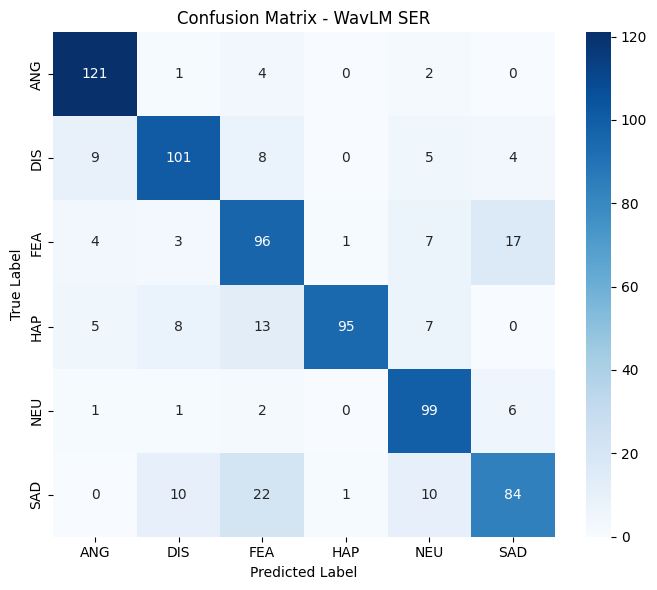

In [26]:
class_names = list(test_dataset.label_encoder.classes_)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - WavLM SER")
plt.tight_layout()
plt.show()


In [27]:
# Unweighted Average Recall
_, recall_per_class, _, _ = precision_recall_fscore_support(
    y_true,
    y_pred,
    average=None
)

uar = np.mean(recall_per_class)
print(f"UAR (Unweighted Avg Recall): {uar:.4f}")


UAR (Unweighted Avg Recall): 0.8004


In [ ]:
url notebook sẵn chạy test, model đã đẩy lên kaggle

https://www.kaggle.com/code/khenguyn/testwalm